# Compare calculation of E data from an electric dipole using the cyl mesh

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import sympy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

import CasingSimulations

from pymatsolver import Pardiso

%matplotlib inline

In [2]:
from SimPEG.EM import Analytics

In [3]:
# conductivity of the wholespace

sigma_back = 1e-1
freqs = np.r_[0.1, 1, 10.]

print(500./np.sqrt(sigma_back * freqs))

[ 5000.          1581.13883008   500.        ]


In [115]:
csx, ncx, npadx = 1, 20, 40
ncy = 32
csz, ncz, npadz = 1, 20, 40

hx = Utils.meshTensor([(csx, ncx), (csx, npadx, 1.2)])
hy = 2*np.pi / ncy * np.ones(ncy)
hz = Utils.meshTensor([(csz, npadz, -1.2), (csz, ncz), (csz, npadz, 1.2)])

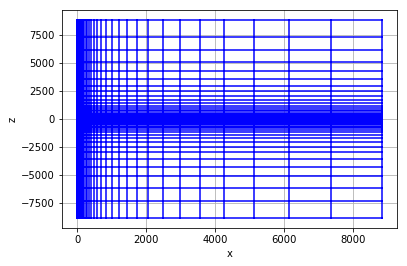

In [52]:
mesh2D = discretize.CylMesh([hx, 1., hz], x0='00C')
mesh2D.plotGrid()

In [53]:
mesh3D = discretize.CylMesh([hx, hy, hz], x0='00C')

In [54]:
# put the source at the center

def getFaceSrc(mesh):

    srcInd = (
        (mesh.gridFz[:,0] < csx) &
        (mesh.gridFz[:,2] < csz/2.) & (mesh.gridFz[:,2] > -csz/2.)
    )
    
    src_vecz = np.zeros(mesh.nFz, dtype=complex)
    src_vecz[srcInd] = 1.
    
    return np.hstack([np.zeros(mesh.vnF[:2].sum(), dtype=complex), src_vecz])

In [55]:
s_e2D = getFaceSrc(mesh2D)
s_e3D = getFaceSrc(mesh3D)

In [56]:
print(mesh2D.gridFz[s_e2D[mesh2D.vnF[:2].sum():].nonzero()])
print(mesh3D.gridFz[s_e3D[mesh3D.vnF[:2].sum():].nonzero()])

[[  5.00000000e-01   0.00000000e+00   1.81898940e-12]]
[[  5.00000000e-01   1.96349541e-01   1.81898940e-12]
 [  5.00000000e-01   5.89048623e-01   1.81898940e-12]
 [  5.00000000e-01   9.81747704e-01   1.81898940e-12]
 [  5.00000000e-01   1.37444679e+00   1.81898940e-12]
 [  5.00000000e-01   1.76714587e+00   1.81898940e-12]
 [  5.00000000e-01   2.15984495e+00   1.81898940e-12]
 [  5.00000000e-01   2.55254403e+00   1.81898940e-12]
 [  5.00000000e-01   2.94524311e+00   1.81898940e-12]
 [  5.00000000e-01   3.33794219e+00   1.81898940e-12]
 [  5.00000000e-01   3.73064128e+00   1.81898940e-12]
 [  5.00000000e-01   4.12334036e+00   1.81898940e-12]
 [  5.00000000e-01   4.51603944e+00   1.81898940e-12]
 [  5.00000000e-01   4.90873852e+00   1.81898940e-12]
 [  5.00000000e-01   5.30143760e+00   1.81898940e-12]
 [  5.00000000e-01   5.69413668e+00   1.81898940e-12]
 [  5.00000000e-01   6.08683577e+00   1.81898940e-12]]


In [57]:
# set up the src list
srcList2D = [FDEM.Src.RawVec_e([], f, s_e2D) for f in freqs]
srcList3D = [FDEM.Src.RawVec_e([], f, s_e3D) for f in freqs]

In [58]:
prob2D = FDEM.Problem3D_h(mesh2D, sigmaMap=Maps.IdentityMap(mesh2D), Solver=Pardiso)
prob3D = FDEM.Problem3D_h(mesh3D, sigmaMap=Maps.IdentityMap(mesh3D), Solver=Pardiso)

survey2D = FDEM.Survey(srcList2D)
survey3D = FDEM.Survey(srcList3D)

prob2D.pair(survey2D)
prob3D.pair(survey3D)

In [59]:
%%time

fields2D = prob2D.fields(sigma_back*np.ones(mesh2D.nC))

CPU times: user 177 ms, sys: 8.84 ms, total: 185 ms
Wall time: 153 ms


In [60]:
%%time

fields3D = prob3D.fields(sigma_back*np.ones(mesh3D.nC))

CPU times: user 8min 14s, sys: 13.1 s, total: 8min 27s
Wall time: 4min 43s


# plot the current density

In [61]:
def getj3Dplot(j3D, theta_ind=0):
    j3D_x = j3D[:mesh3D.nFx].reshape(mesh3D.vnFx, order='F')
    j3D_z = j3D[mesh3D.vnF[:2].sum():].reshape(mesh3D.vnFz, order='F')
    
    j3Dplt = np.vstack([utils.mkvc(j3D_x[:,theta_ind,:],2), utils.mkvc(j3D_z[:,theta_ind,:],2)])
    
    return j3Dplt

In [62]:
freq_plt = 1

j2D = fields2D[srcList2D[freq_plt], 'j']
j3D = fields3D[srcList3D[freq_plt], 'j']

j3Dplt = getj3Dplot(j3D)

In [63]:
def plotJcomparison(j1, j2, real_or_imag='real', ax=None):
    if len(j1) == mesh2D.nF:
        vType = 'F'
    elif len(j1) == mesh2D.nC*2:
        vType = 'CCv'
    
    if ax is None:
        fig, ax = plt.subplots(1,3, figsize=(10, 4))

    plt.colorbar(
    mesh2D.plotImage(
            getattr(j1, real_or_imag), view='vec', vType=vType, ax=ax[0], range_x=np.r_[-50, 50], range_y=np.r_[-50., 50.], mirror=True, 
            pcolorOpts={
                'norm':LogNorm()
            },
        )[0], ax=ax[0]
    )

    plt.colorbar(
        mesh2D.plotImage(
            getattr(j2, real_or_imag), view='vec', vType=vType, ax=ax[1], range_x=np.r_[-50, 50], range_y=np.r_[-50., 50.], mirror=True, 
            pcolorOpts={
                'norm':LogNorm()
            },
        )[0], ax=ax[1]
    )


    plt.colorbar(
        mesh2D.plotImage(
            getattr((j1 - j2), real_or_imag), view='vec', vType=vType, ax=ax[2], range_x=np.r_[-50, 50], range_y=np.r_[-50., 50.], mirror=True, 
             pcolorOpts={'norm':LogNorm()
            },
        )[0], ax=ax[2]
    )

    plt.tight_layout()

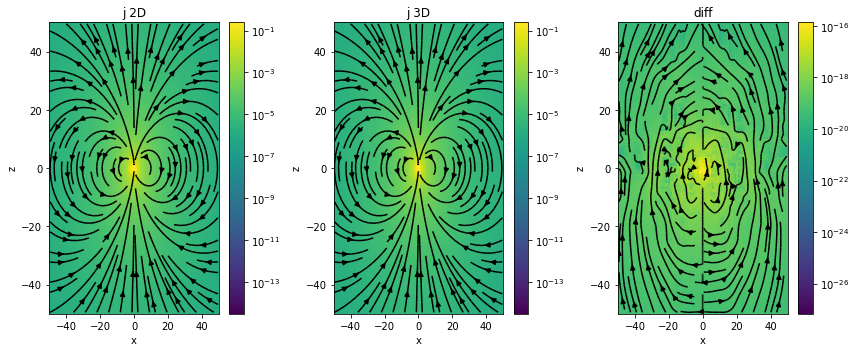

In [64]:
fig, ax = plt.subplots(1,3, figsize=(12, 5))

plotJcomparison(j2D, j3Dplt, ax=ax)

ax[0].set_title('j 2D')
ax[1].set_title('j 3D')
ax[2].set_title('diff')

plt.tight_layout()

# Compare current density with analytic

In [65]:
eana_x, _, _ = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh2D.gridFx, np.r_[0., 0., 0.], sig=sigma_back, f=np.r_[freqs[freq_plt]], current=csx**2 * np.pi, 
    length=1., orientation='Z'
)
_, _, eana_z = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh2D.gridFz, np.r_[0., 0., 0.], sig=sigma_back, f=np.r_[freqs[freq_plt]], current=csx**2 * np.pi, 
    length=1., orientation='Z'
)
eana = utils.mkvc(np.hstack([eana_x, eana_z]),2)
jana = sigma_back * eana

eccx, _, eccz = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh2D.gridCC, np.r_[0., 0., 0.], sig=sigma_back, f=np.r_[freqs[freq_plt]], current=csx**2 * np.pi, 
    length=1., orientation='Z'    
)

ecc_ana = utils.mkvc(np.hstack([eccx, eccz]),2)

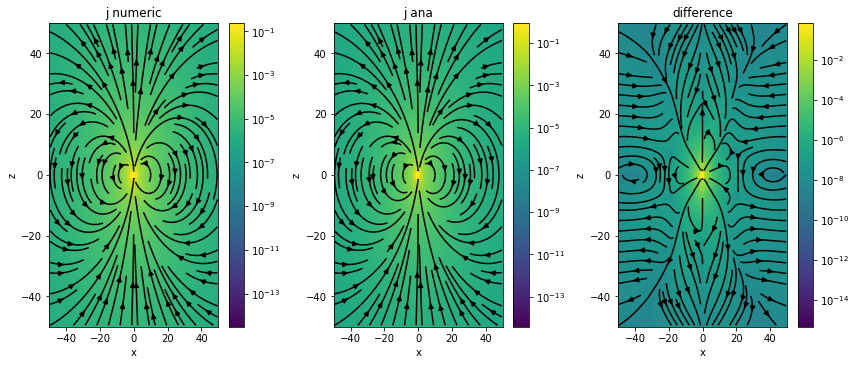

In [66]:
fig, ax = plt.subplots(1,3, figsize=(12, 5))

plotJcomparison(j3Dplt, jana, ax=ax, real_or_imag='real')

ax[0].set_title('j numeric')
ax[1].set_title('j ana')
ax[2].set_title('difference')

# Look at electric fields

In [67]:
e3D = fields3D[srcList3D[freq_plt], 'e']
e2D = fields2D[srcList2D[freq_plt], 'e']

In [68]:
len(e3D) / mesh3D.nC

3

In [69]:
def gete3Dplot(e3D, theta_ind=0):
    e3D_x = e3D[:mesh3D.nC].reshape(mesh3D.vnC, order='F')
    e3D_z = e3D[mesh3D.nC*2:].reshape(mesh3D.vnC, order='F')
    
    e3Dplt = np.vstack([utils.mkvc(e3D_x[:,theta_ind,:],2), utils.mkvc(e3D_z[:,theta_ind,:],2)])
    
    return e3Dplt

In [70]:
e3Dplt = gete3Dplot(e3D)

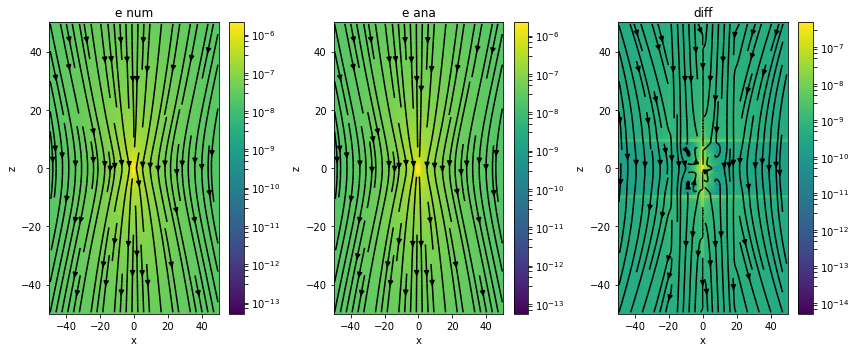

In [71]:
fig, ax = plt.subplots(1,3, figsize=(12, 5))

plotJcomparison(e3Dplt, ecc_ana, ax=ax, real_or_imag='imag')

ax[0].set_title('e num')
ax[1].set_title('e ana')
ax[2].set_title('diff')

plt.tight_layout()

In [72]:
# line plots
e3D_x = e3Dplt[:mesh2D.nC].reshape([mesh2D.vnC[0], mesh2D.vnC[2]], order='F')
e3D_z = e3Dplt[mesh2D.nC:].reshape([mesh2D.vnC[0], mesh2D.vnC[2]], order='F')

e2D_x = e2D[:mesh2D.nC].reshape([mesh2D.vnC[0], mesh2D.vnC[2]], order='F')
e2D_z = e2D[mesh2D.nC:].reshape([mesh2D.vnC[0], mesh2D.vnC[2]], order='F')

eana_x = ecc_ana[:mesh2D.nC].reshape([mesh2D.vnC[0], mesh2D.vnC[2]], order='F')
eana_z = ecc_ana[mesh2D.nC:].reshape([mesh2D.vnC[0], mesh2D.vnC[2]], order='F')

In [73]:
def plot_lines(x, e2D=None, e3D=None, eana=None, xlim=[0., 100.], name=None):
    fig, ax = plt.subplots(3, 2, figsize=(12,8))
    ax = utils.mkvc(ax)
    
    plt_ind = (x > xlim[0]) & (x < xlim[1])
    
    x = x[plt_ind]
    if e2D is not None: e2D = e2D[plt_ind]
    if e3D is not None: e3D = e3D[plt_ind]
    if eana is not None: eana = eana[plt_ind]
    
    # Plot real
    if any(eana.real > 0): 
        if e2D is not None: ax[0].semilogy(x, e2D.real, '-b', label='2D')
        if e3D is not None: ax[0].semilogy(x, e3D.real, '-g', label='3D')
        if eana is not None: ax[0].semilogy(x, eana.real, '-r', label='ana')
    if any(eana.real < 0): 
        if e2D is not None: ax[0].semilogy(x, -e2D.real, '--b', label='2D')
        if e3D is not None: ax[0].semilogy(x, -e3D.real, '--g', label='3D')
        if eana is not None: ax[0].semilogy(x, -eana.real, '--r', label='ana')
        
    ax[0].set_xlim(xlim)
    ax[0].set_title('{} real'.format(name))
    ax[0].legend()


    if e2D is not None: ax[1].semilogy(x, np.absolute(e2D.real - eana.real), '-b', label='2D')
    if e3D is not None: ax[1].semilogy(x, np.absolute(e3D.real - eana.real), '-g', label='3D')

    ax[1].set_xlim(xlim)
    ax[1].set_title('{} error real'.format(name))
    ax[1].legend()

    if e2D is not None: ax[2].plot(
        x, (e2D.real - eana.real)/(eana.real), '-b', label='2D'
    )
    if e3D is not None: ax[2].plot(
        x, (e3D.real - eana.real)/(eana.real), '-g', label='3D'
    )

    ax[2].set_xlim(xlim)
    ax[2].set_ylim(0.05*np.r_[-1, 1])
    ax[2].set_title('{} error real'.format(name))
    ax[2].legend()

    if any(eana.imag > 0):
        if e2D is not None: ax[3].semilogy(x, e2D.imag, '-b', label='2D')
        if e3D is not None: ax[3].semilogy(x, e3D.imag, '-g', label='3D')
        ax[3].semilogy(x, eana.imag, '-r', label='ana')
    if any(eana.imag < 0): 
        if e2D is not None: ax[3].semilogy(x, -e2D.imag, '--b', label='2D')
        if e3D is not None: ax[3].semilogy(x, -e3D.imag, '--g', label='3D')
        ax[3].semilogy(x, -eana.imag, '--r', label='ana')
        
    ax[3].set_title('{} imag'.format(name))
    ax[3].set_xlim(xlim)
    ax[3].legend()

    if e2D is not None: ax[4].semilogy(x, np.absolute(e2D.imag - eana.imag), '-b', label='2D')
    if e3D is not None: ax[4].semilogy(x, np.absolute(e3D.imag - eana.imag), '-g', label='3D')

    ax[4].set_xlim(xlim)
    ax[4].set_title('{} error imag'.format(name))
    ax[4].legend()

    if e2D is not None: ax[5].plot(
        x, (e2D.imag - eana.imag)/(eana.imag), '-b', label='2D'
    )
    if e3D is not None: ax[5].plot(
        x, (e3D.imag - eana.imag)/(eana.imag), '-g', label='3D'
    )

    ax[5].set_xlim(xlim)
    ax[5].set_ylim(0.05*np.r_[-1, 1])
    ax[5].set_title('{} error imag'.format(name))
    ax[5].legend()
    
    plt.tight_layout()
    
    return fig, ax

    

looking at z=10.6


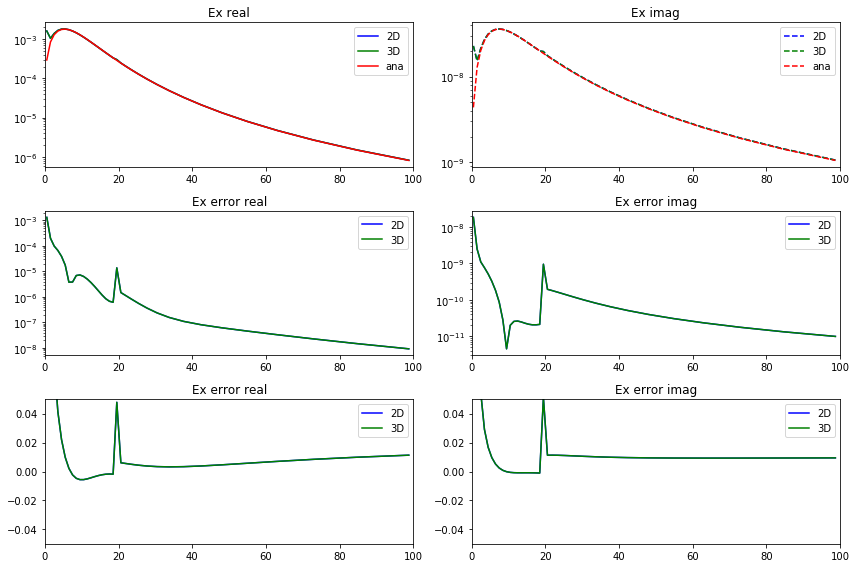

In [74]:
z_ind = mesh2D.vnC[2]/2 + 10
print('looking at z={}'.format(mesh2D.vectorCCz[z_ind]))

fig, ax = plot_lines(mesh2D.vectorCCx, e2D_x[:, z_ind], e3D_x[:, z_ind], eana_x[:, z_ind], xlim=[0., 100.], name='Ex')

looking at z=10.6


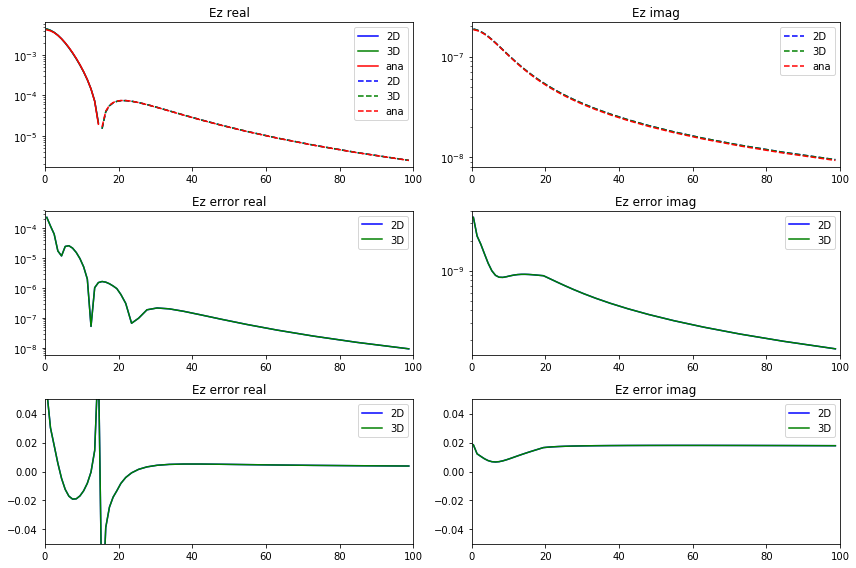

In [75]:
z_ind = mesh2D.vnC[2]/2 + 10
print('looking at z={}'.format(mesh2D.vectorCCz[z_ind]))

fig, ax = plot_lines(mesh2D.vectorCCx, e2D_z[:, z_ind], e3D_z[:, z_ind], eana_z[:, z_ind], xlim=[0., 100.], name='Ez')

looking at x=15.5


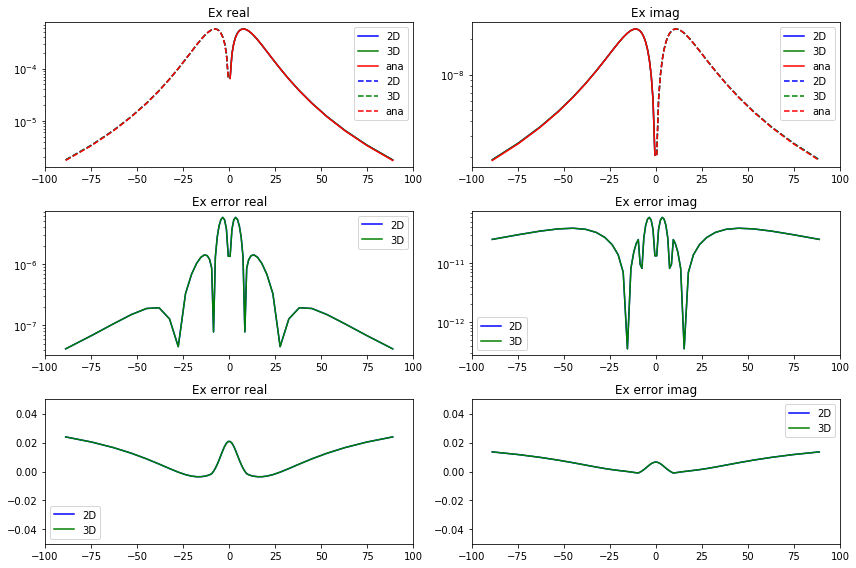

In [76]:
x_ind =  15
print('looking at x={}'.format(mesh2D.vectorCCx[x_ind]))

fig, ax = plot_lines(mesh2D.vectorCCz, e2D_x[x_ind, :], e3D_x[x_ind, :], eana_x[x_ind, :], xlim=[-100., 100.], name='Ex')

looking at x=15.5


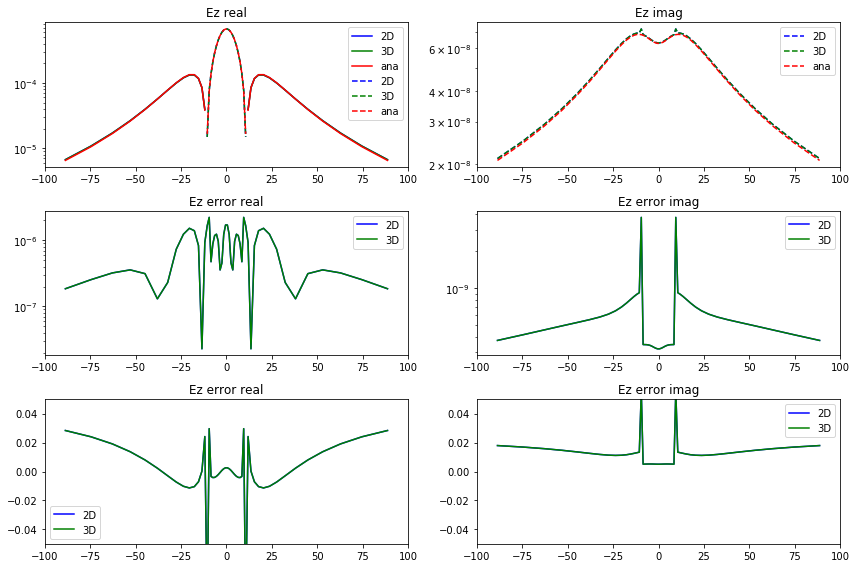

In [77]:
x_ind =  15
print('looking at x={}'.format(mesh2D.vectorCCx[x_ind]))

fig, ax = plot_lines(mesh2D.vectorCCz, e2D_z[x_ind, :], e3D_z[x_ind, :], eana_z[x_ind, :], xlim=[-100., 100.], name='Ez')

# edge source with e-b formulation for 3D mesh

In [116]:
srcInd = (
    (mesh3D.gridEz[:,0] < csx/2.) &
    (mesh3D.gridEz[:,2] < csz/2.) & (mesh3D.gridEz[:,2] > -csz/2.)
)

src_vecz = np.zeros(mesh3D.nEz, dtype=complex)
src_vecz[srcInd] = 1.

src_vec = np.hstack([np.zeros(mesh3D.vnE[:2].sum(), dtype=complex), src_vecz])

In [118]:
srcLoc = mesh3D.gridEz[srcInd, :]
print srcLoc

[[ 0.   0.  -0.5]]


In [119]:
edgeSrcList = [FDEM.SrcFDEM.RawVec_e([], f, src_vec) for f in freqs]

In [120]:
prb3D_e = FDEM.Problem3D_e(mesh3D, sigmaMap=Maps.IdentityMap(mesh3D), Solver=Pardiso)
survey3D_e = FDEM.Survey(edgeSrcList)

prb3D_e.pair(survey3D_e)

In [121]:
%%time
fields3D_e = prb3D_e.fields(sigma_back*np.ones(mesh3D.nC))

CPU times: user 8min 21s, sys: 15.6 s, total: 8min 36s
Wall time: 4min 56s


In [123]:
freq_plt = 1
e3D_cc = mesh3D.aveE2CCV * fields3D_e[edgeSrcList[freq_plt], 'e']
e3D_ccplt = gete3Dplot(e3D_cc)

In [135]:
eccx, _, eccz = Analytics.E_from_ElectricDipoleWholeSpace(
    mesh2D.gridCC, utils.mkvc(srcLoc), sig=sigma_back, f=np.r_[freqs[freq_plt]], current=1., 
    length=1., orientation='Z'    
)

eccE_ana = utils.mkvc(np.hstack([eccx, eccz]), 2)

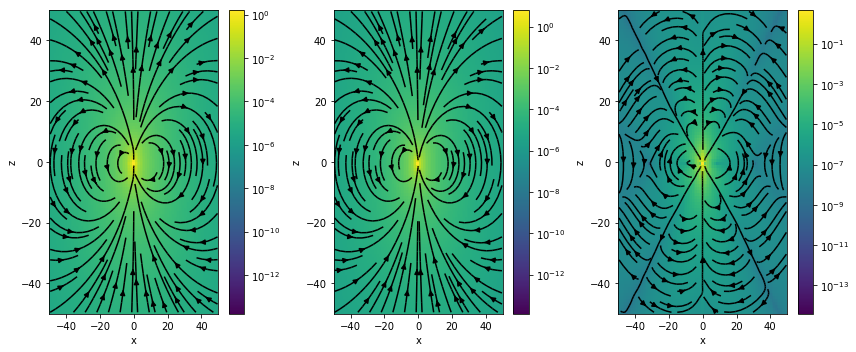

In [136]:
fig, ax = plt.subplots(1,3, figsize=(12, 5))
plotJcomparison(e3D_ccplt, eccE_ana, ax=ax, real_or_imag='real')

In [137]:
e3DE = fields3D_e[edgeSrcList[freq_plt], 'e']
e3DE_x = j3D[:mesh3D.nEx].reshape(mesh3D.vnEx, order='F')
e3DE_z = j3D[mesh3D.vnE[:2].sum():].reshape(mesh3D.vnEz, order='F')

XYZ_x = utils.ndgrid(mesh3D.vectorCCx, np.r_[0.], mesh3D.vectorNz)
eanaE_x, _, _ = Analytics.E_from_ElectricDipoleWholeSpace(
    XYZ_x, utils.mkvc(srcLoc)+ np.ones(3)*1e-12, sig=sigma_back, f=np.r_[freqs[freq_plt]], current=1./np.pi, 
    length=csz, orientation='Z'    
)


XYZ_z = utils.ndgrid(mesh3D.vectorNx, np.r_[0.], mesh3D.vectorCCz)
_, _, eanaE_z = Analytics.E_from_ElectricDipoleWholeSpace(
    XYZ_z, utils.mkvc(srcLoc)+ np.ones(3)*1e-12, sig=sigma_back, f=np.r_[freqs[freq_plt]], current=1./np.pi, 
    length=csz, orientation='Z'    
)

eanaE_x = eanaE_x.reshape([mesh3D.vnEx[0], mesh3D.vnEx[2]], order='F')
eanaE_z = eanaE_z.reshape([mesh3D.vnN[0], mesh3D.vnC[2]], order='F')

looking at z=0.500000000002


(-0.3, 0.0)

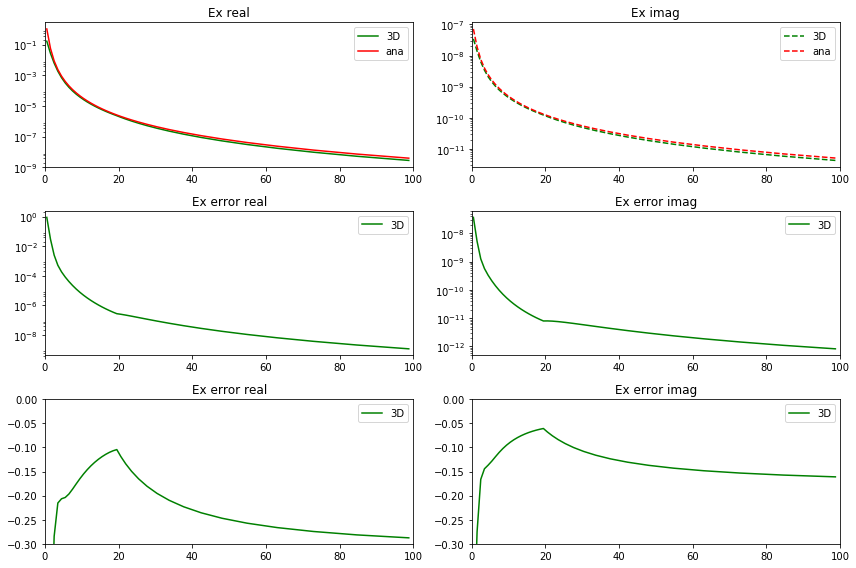

In [138]:
z_ind = mesh3D.vnC[2]/2 
print('looking at z={}'.format(mesh3D.vectorCCz[z_ind]))

fig, ax = plot_lines(mesh3D.vectorCCx, None, e3DE_x[:, 0, z_ind], eanaE_x[:, z_ind], xlim=[0., 100.], name='Ex')
ax[2].set_ylim([-0.3, 0.])
ax[5].set_ylim([-0.3, 0.])

looking at z=2.5


(-1.0, 1.0)

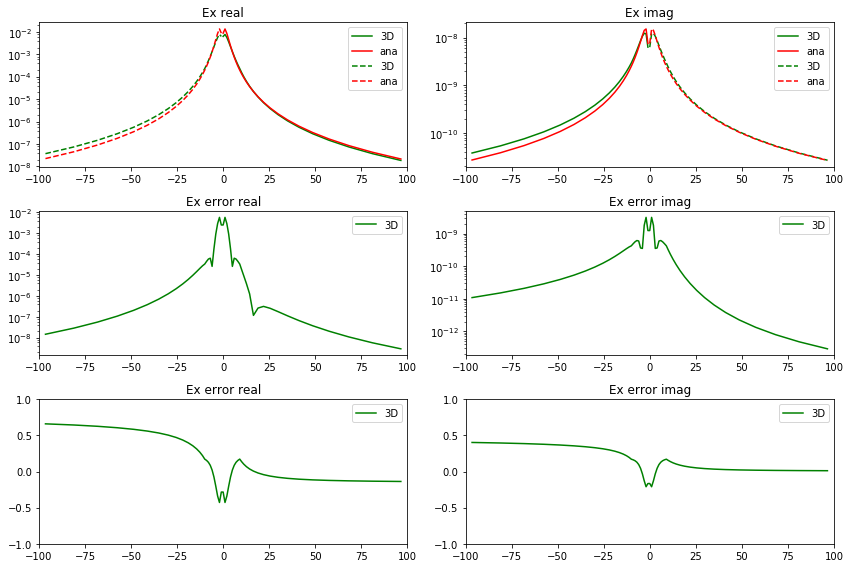

In [140]:
x_ind = 2
print('looking at z={}'.format(mesh3D.vectorCCx[x_ind]))

fig, ax = plot_lines(mesh3D.vectorNz, None, e3DE_x[x_ind, 0, :], eanaE_x[x_ind, :], xlim=[-100., 100.], name='Ex')
ax[2].set_ylim([-1., 1.])
ax[5].set_ylim([-1., 1.])

In [114]:
np.linalg.norm(e3DE_x[:,0,:])

0.25964166401676964

In [90]:
np.linalg.norm(e3DE_x[:,0,:])

0.25964166401676964